# Applied Materials - Stock Analysis Project

In [1]:
# Import all the necessary libraries

# Install required tools
!pip install yfinance
!pip install ta
!pip install joblib

# Data Handling & Manipulation
import pandas as pd
import numpy as np
import datetime

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Technical Indicator
import ta

# Stock Data
import yfinance as yf

# Machine learning Tools

# Data splitting
from sklearn.model_selection import train_test_split

# Machine learning Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Preprocessing & Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# ------------------------------------- 1. Data Collection & Organizing -------------------------------------

In [3]:
# Define stock tickers
companies = {'Applied Materials': 'AMAT',
             'ASML': 'ASML',
             'Lam Research': 'LRCX',
             'KLA': 'KLAC',
             'S&P 500': '^GSPC'}

# Define start and end date
end_date = datetime.datetime.today()
start_date = '2018-01-01'

# Pull adjusted close prices from 2018 to end of 2024
stock_data = yf.download(list(companies.values()), start = start_date, end = end_date)
stock_data = stock_data['Close']

# Rename columns for clarity
stock_data.columns = list(companies.keys())

stock_data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


,Applied Materials,ASML,Lam Research,KLA,S&P 500
Date,,,,,
2018-01-02,48.807011,165.734268,94.420517,9.839666,2695.810059
2018-01-03,49.671982,166.993179,95.523712,10.007057,2713.060059
2018-01-04,49.957253,168.550461,95.692757,10.052804,2723.989990
2018-01-05,50.242516,170.527374,97.738983,10.209795,2743.149902
2018-01-08,51.457161,171.422577,98.005890,10.286736,2747.709961


In [4]:
# Get basic information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1822 entries, 2018-01-02 to 2025-04-01
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Applied Materials  1822 non-null   float64
 1   ASML               1822 non-null   float64
 2   Lam Research       1822 non-null   float64
 3   KLA                1822 non-null   float64
 4   S&P 500            1822 non-null   float64
dtypes: float64(5)
memory usage: 85.4 KB


In [5]:
# Data statistics
stock_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Applied Materials,1822.0,103.074314,54.493933,27.106487,50.873138,104.264343,138.637192,253.301788
ASML,1822.0,502.375227,250.605535,136.420395,238.364323,546.751556,694.458649,1094.355713
Lam Research,1822.0,329.737423,212.340532,74.252151,141.631989,307.721588,445.617455,886.253845
KLA,1822.0,41.000926,25.473972,7.827748,16.142091,41.099312,57.391983,108.649010
S&P 500,1822.0,3919.524275,975.722976,2237.399902,2952.397522,3939.965088,4498.942383,6144.149902


In [6]:
# ------------------------------------- 2. Trend Visualizations & Return Analysis -------------------------------------

In [7]:
# Normalize the stock data to avoid scale mismatch and to show relative growth
normalized_data = stock_data / stock_data.iloc[0]

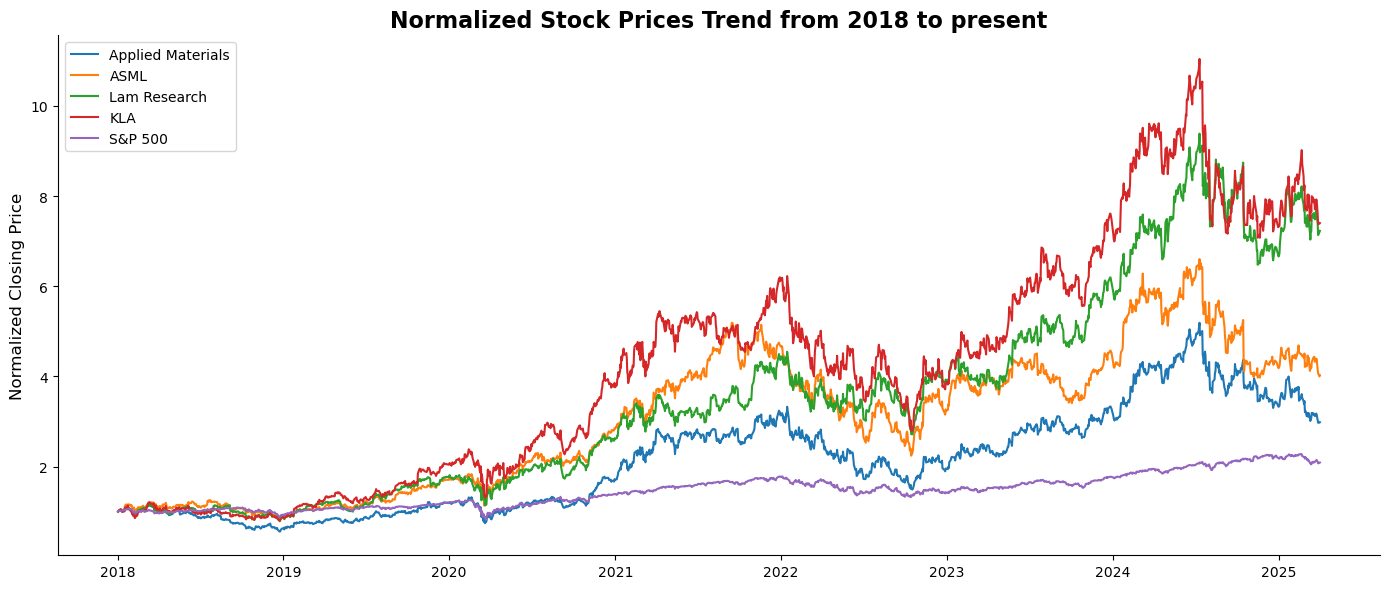

In [8]:
# Plot stock prices over time
plt.figure(figsize = (14, 6))
for column in normalized_data.columns:
    plt.plot(normalized_data.index, normalized_data[column], label = column)

plt.title('Normalized Stock Prices Trend from 2018 to present', 
          fontsize = 16,
          fontweight = 'bold')

plt.ylabel('Normalized Closing Price',
           fontsize = 12)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

In [9]:
# Caculate the daily returns for stock price
daily_returns = stock_data.pct_change().dropna()

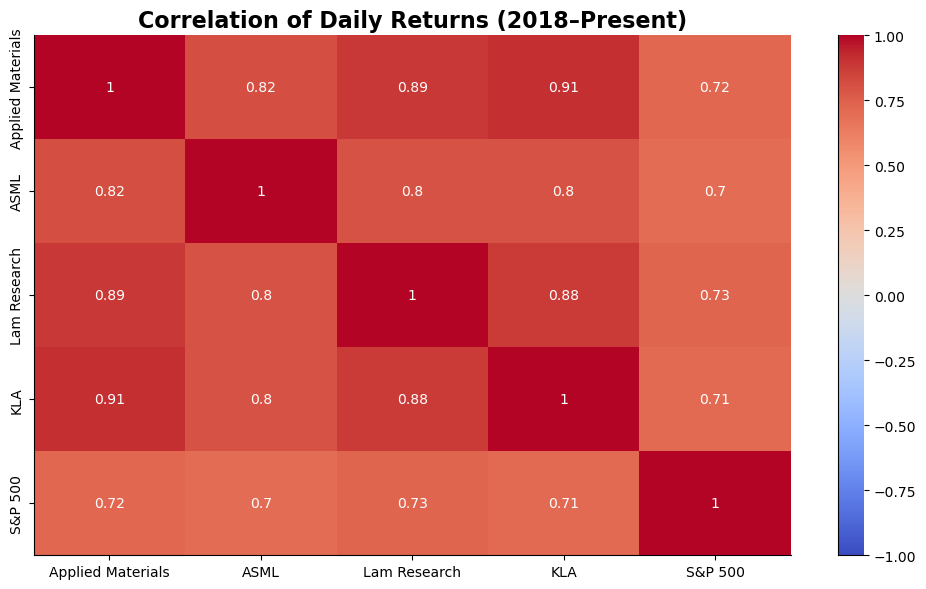

In [10]:
# Compute the correlation matrix of returns
return_corr = daily_returns.corr()

# Plot the heatmap
plt.figure(figsize = (10,6))
sns.heatmap(return_corr, annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.title('Correlation of Daily Returns (2018–Present)', 
          fontsize = 16, 
          fontweight = 'bold')
sns.despine()
plt.tight_layout()
plt.show()

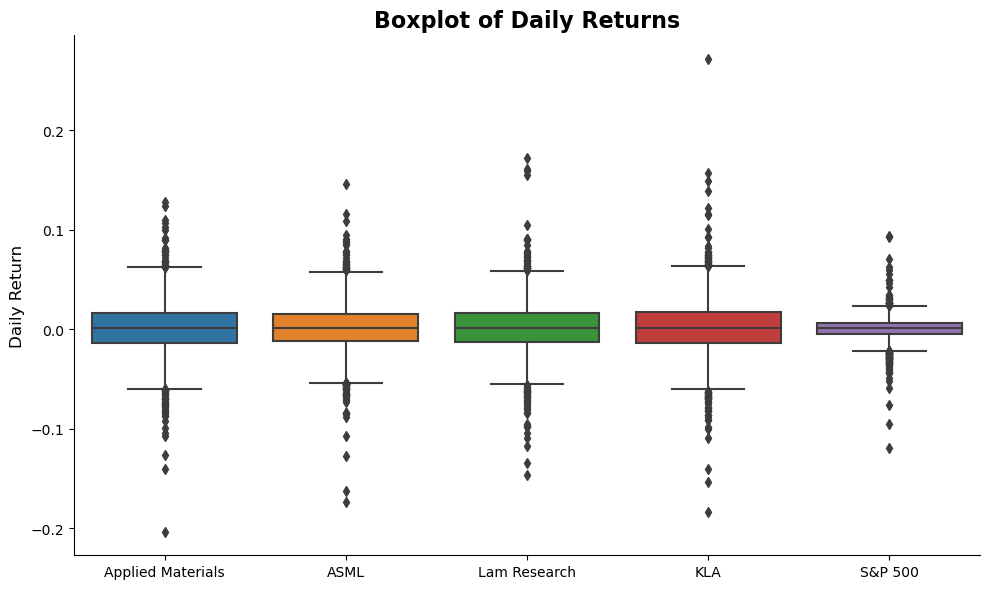

In [11]:
# Boxplot for daily returns
plt.figure(figsize = (10, 6))
sns.boxplot(data = daily_returns)
plt.title('Boxplot of Daily Returns',
          fontsize = 16,
          fontweight = 'bold')
plt.ylabel('Daily Return', 
           fontsize = 12)
sns.despine()
plt.tight_layout()
plt.show()

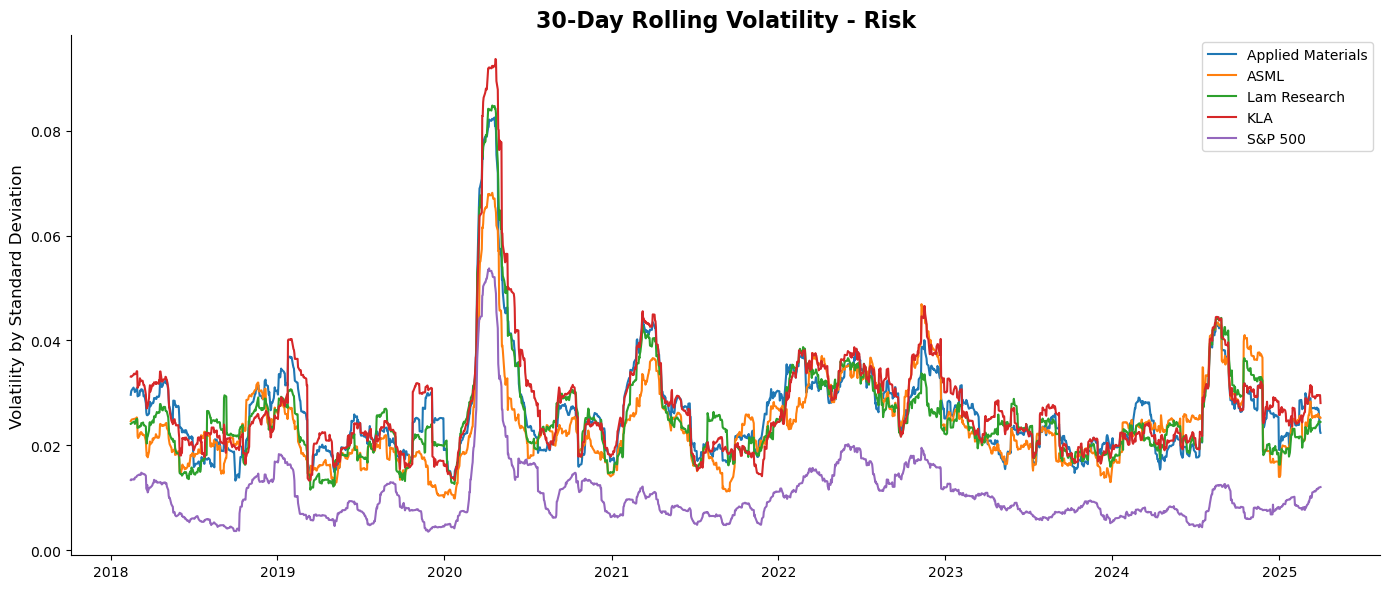

In [12]:
# Calculate 30-day rolling standard deviation of daily returns
rolling_vol = daily_returns.rolling(window = 30).std()

# Plot rolling volatility
plt.figure(figsize = (14, 6))
for column in rolling_vol.columns:
    plt.plot(rolling_vol.index, rolling_vol[column], label = column)

plt.title('30-Day Rolling Volatility - Risk',
          fontsize = 16,
          fontweight = 'bold')
plt.ylabel('Volatility by Standard Deviation',
           fontsize = 12)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

In [13]:
# ------------------------------------- 3. Machine Learning Models for AMAT Stock Forecast -------------------------------------

In [14]:
# Work on AMAT only from now
df_AMAT = stock_data[['Applied Materials']].copy()
df_AMAT.columns = ['Close']
df_AMAT.head()

,Close
Date,
2018-01-02,48.807011
2018-01-03,49.671982
2018-01-04,49.957253
2018-01-05,50.242516
2018-01-08,51.457161


In [15]:
# Calculating the features for the machine learning models

# Calculate daily return
df_AMAT['return'] = df_AMAT['Close'].pct_change()

# Calculate the moving averages
df_AMAT['MA_5'] = df_AMAT['Close'].rolling(window = 5).mean()
df_AMAT['MA_10'] = df_AMAT['Close'].rolling(window = 10).mean()
df_AMAT['MA_20'] = df_AMAT['Close'].rolling(window = 20).mean()

# Calculate the RSI - Relative Strength Index
from ta.momentum import RSIIndicator
df_AMAT['RSI'] = RSIIndicator(close = df_AMAT['Close'], window = 14).rsi()

# Define the target as the tomorrow's closing price using today's closing price
df_AMAT['Target'] = df_AMAT['Close'].shift(-1)

# Drop missing values
df_AMAT.dropna(inplace=True)

In [16]:
df_AMAT.head()

,Close,return,MA_5,MA_10,MA_20,RSI,Target
Date,,,,,,,
2018-01-30,49.119865,-0.035243,51.249200,52.070012,50.932653,41.549514,49.349926
2018-01-31,49.349926,0.004684,50.651076,51.728622,50.959799,42.997029,49.027855
2018-02-01,49.027855,-0.006526,50.194660,51.349502,50.927593,41.449467,46.635357
2018-02-02,46.635357,-0.048799,49.009452,50.731132,50.761498,32.182891,44.454491
2018-02-05,44.454491,-0.046764,47.717499,49.889155,50.472097,26.391023,46.239666


In [17]:
# Define features and target
X = df_AMAT.drop(['Target'], axis = 1)
y = df_AMAT['Target']

In [18]:
# Manual split to avoid breaking the chronological order
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [19]:
# Train Random Forest Model
model_forest = RandomForestRegressor(n_estimators = 500, random_state = 42, max_leaf_nodes = 20)

# Initialize model
model_forest.fit(X_train, y_train)

# Predict the target
y_pred = model_forest.predict(X_test)

# Evaluate the model using the MSE root and MAE
RMSE = round(np.sqrt(mean_squared_error(y_pred, y_test)), 3)
MAE =  round(mean_absolute_error(y_pred, y_test), 3)

print('RMSE: ', RMSE)
print('MAE: ', MAE)

RMSE:  42.023
MAE:  34.019


In [20]:
# Train Linear Regression Model
model_linreg = Pipeline([
    ('Polynomial Features', PolynomialFeatures(degree = 2)),
    ('Linear Regression', LinearRegression())
])

# Fit the model
model_linreg.fit(X_train, y_train)

# Predict
y_pred_linreg = model_linreg.predict(X_test)

# Evaluate
RMSE_linreg = round(np.sqrt(mean_squared_error(y_pred_linreg, y_test)), 3)
MAE_linreg =  round(mean_absolute_error(y_pred_linreg, y_test), 3)

print('RMSE: ', RMSE_linreg)
print('MAE: ', MAE_linreg)

RMSE:  5.414
MAE:  4.028


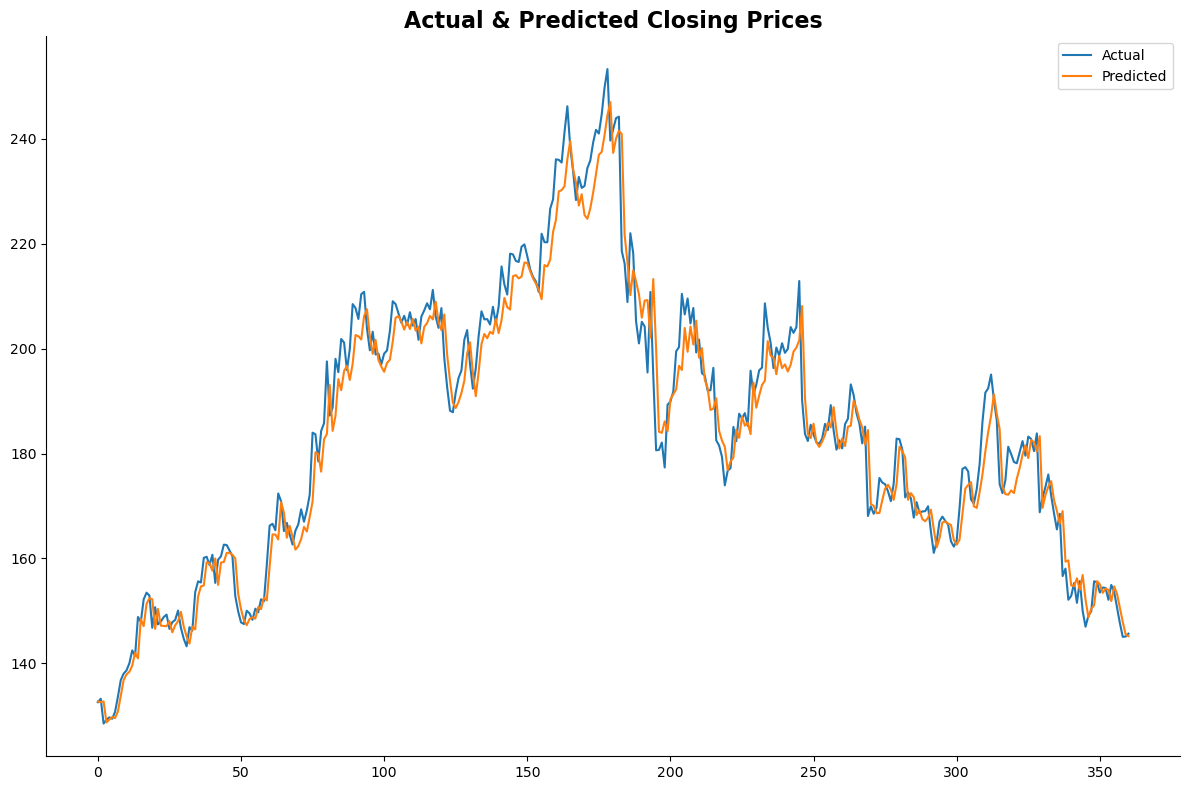

In [21]:
# Plot the actual & predicted price for the linear regression model
plt.figure(figsize = (12, 8))
plt.plot(y_test.values, label = 'Actual')
plt.plot(y_pred_linreg, label = 'Predicted')
plt.title("Actual & Predicted Closing Prices",
          fontsize = 16,
          fontweight = 'bold')
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

In [22]:
# Save the model
import joblib
joblib.dump(model_linreg, 'polynomial_linear_model.pkl')

['polynomial_linear_model.pkl']

In [23]:
# ------------------------------------- The End -------------------------------------